In [1]:
import gym
import numpy as np
import ptan

import torch
import torch.nn as nn
import torch.optim as optim

import collections

import warnings
warnings.filterwarnings('ignore')

## Deep Q-Network

In [2]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        return self.fc(x)

## Agent

In [3]:
# an agent has an env, an experience buffer, a Q(s,a) network
class DQNAgent:
    def __init__(self, dqn_model, action_selector, device="cpu"):
        self.dqn_model = dqn_model
        self.action_selector = action_selector
        self.device = device

    @torch.no_grad()
    def __call__(self, states):
        np_states = np.array(states, dtype=np.float32)
        states = torch.FloatTensor(np_states).to(self.device)
        q_v = self.dqn_model(states)
        q = q_v.data.cpu().numpy()
        actions = self.action_selector(q)
        return actions

class EpsilonGreedyActionSelector():
    def __init__(self, epsilon = 0.05):
        self.epsilon = epsilon
    
    def __call__(self, Qs):
        batch_size, n_actions = Qs.shape
        mask = np.random.random(size=batch_size) < self.epsilon
        actions = np.argmax(Qs, axis=1)
        rand_actions = np.random.choice(n_actions, sum(mask))
        actions[mask] = rand_actions
        return actions

In [4]:
# test it
device = "cpu"
env = gym.make('CartPole-v0')
net = DQN(env.observation_space.shape[0], env.action_space.n)
selector = EpsilonGreedyActionSelector(epsilon = 1.0)
agent = DQNAgent(net, selector, device=device)

In [5]:
s0 = env.reset()
print('env s0: ', s0)

s0_v = torch.FloatTensor([s0]).to(device)
print('Q(s0,a) = ',net(s0_v)) # Q(s0, a) -- values for a = 0,1

agent([s0])

env s0:  [ 0.0490368  -0.0391244   0.04400133  0.00015087]
Q(s0,a) =  tensor([[-0.1712, -0.0754]], grad_fn=<AddmmBackward>)


array([1])

## Experience Buffer

In [6]:
# each experience is a tuple (s,a,r,s')
ExperienceFirstLast = collections.namedtuple('ExperienceFirstLast',('state', 'action', 'reward', 'last_state'))
Experience = collections.namedtuple('Experience',('state','action', 'reward', 'done'))

# make a class that runs the env with the choosen agent + action selection method for n-steps
# and yields an experience object
class ExperienceSourceFirstLast():
    def __init__(self, env, agent, gamma, steps_count=1):
        self.env = env
        self.agent = agent
        self.gamma = gamma
        self.steps = steps_count + 1

    def __iter__(self):
        state = self.env.reset() # initialization of the environment
        
        while True:
            exp_chain = [] # store a chain of experiences
            
            # take n-steps under the chosen agent policy
            for step in range(self.steps):
                action = self.agent([state])[0]
                new_state, reward, done, info = self.env.step(action)
                exp_chain.append(Experience(state,action,reward,done))
                state = new_state
                if done:
                    state = self.env.reset() # reset for the next iteration
                    break
            
            # if the chain ends prematurely fill the last state value with None
            if done and len(exp_chain) <= self.steps:
                last_state = None
                elems = exp_chain
            else:
                last_state = exp_chain[-1].state
                elems = exp_chain[:-1]
            
            # compute the discounted reward along the n-step experience chain
            total_reward = 0.0
            for e in reversed(elems):
                total_reward *= self.gamma
                total_reward += e.reward
                
            yield ExperienceFirstLast(state=exp_chain[0].state, action=exp_chain[0].action,
                                      reward=total_reward, last_state=last_state)

In [7]:
# testing the experience generator
exp_source = ExperienceSourceFirstLast(env, agent, gamma=0.99, steps_count=1)

In [8]:
xp_iterator = exp_source.__iter__()

In [9]:
next(xp_iterator)

ExperienceFirstLast(state=array([-0.02190805, -0.02405678, -0.03360517,  0.04785251]), action=0, reward=1.0, last_state=array([-0.02238919, -0.21868114, -0.03264812,  0.32974617]))

## Priority Experience Replay Buffer

In [10]:
class PriorityReplayBuffer:
    def __init__(self, exp_source, buf_size, prob_alpha=0.6):
        self.exp_source_iter = iter(exp_source)
        self.prob_alpha = prob_alpha
        self.capacity = buf_size
        self.pos = 0
        self.buffer = []
        # each experience in the buffer will be assigned a "priority"
        # initialize each priority to 0
        # the priorities will be the loss for each experience, this
        # will be used to set the probablity of selecting that 
        # experience in other batches, where the more wrong the loss
        # the more likely it is to be selected, so it can train on it better
        self.priorities = np.zeros((buf_size,), dtype=np.float32)
    
    def __len__(self):
        return len(self.buffer)
    
    def populate(self, count):
        # what is the maximum priority in the buffer if it is not empty?
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        # sample "count," experiences, and keep track of the oldest experience in the buffer
        # by tracking it's position within the buffer
        for _ in range(count):
            sample = next(self.exp_source_iter) # generate/get the next experience (s,a,r,s')
            
            if len(self.buffer) < self.capacity:
                self.buffer.append(sample) # append to the buffer if the buffer isn't full
            else:
                self.buffer[self.pos] = sample # replace the oldest experience in the buffer with the new one
                
            self.priorities[self.pos] = max_prio # set the priority of the current experience to the max so,
                                                 # that its very likely to get sampled, since it hasn't
                                                 # been seen before in any batch
            
            self.pos = (self.pos + 1) % self.capacity # cyclic the oldest xp index to the next one
    
    def sample(self, batch_size, beta=0.4):
        
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        # convert priority numbers to probabilities via
        # P(i) = priority_i**alpha/(sum(priority_i**alpha))
        probs = prios ** self.prob_alpha
        probs /= probs.sum()
        
        # randomly select from the experience buffer, a batch size sample, with probabilities
        # of experience selection = probs
        indices = np.random.choice(len(self.buffer), batch_size, p=probs, replace=True)
        samples = [self.buffer[idx] for idx in indices]
        
        # because we pull from from a non-uniform sample
        # we need compute the importance sampling weight for 
        # SGD to work, we kind of cheat here by adding a beta
        # in pure importance sampling beta = 1
        total = len(self.buffer)
        weights = (total*probs[indices])**(-beta)
        weights /= weights.max()
        
        # return the samples, the weights, and indices, where the indices
        # are going to be used to update their priorities after the loss
        # is computed on them
        return(samples, indices, np.array(weights, dtype=np.float32))
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

In [11]:
# Testing the Priority Experience Replay Buffer
PRIO_REPLAY_ALPHA = 0.6
BETA_START = 0.4
BETA_FRAMES = 100000

buffer = PriorityReplayBuffer(exp_source, buf_size=100000, prob_alpha=PRIO_REPLAY_ALPHA)

In [12]:
buffer.populate(100)

In [13]:
buffer.sample(2)

([ExperienceFirstLast(state=array([-0.00594854, -0.04855491,  0.00448236, -0.03883723]), action=1, reward=1.0, last_state=array([-0.00691964,  0.14650248,  0.00370562, -0.33010256])),
  ExperienceFirstLast(state=array([-0.00361714,  0.38085467, -0.04323775, -0.75533925]), action=1, reward=1.0, last_state=array([ 0.00399996,  0.57654513, -0.05834454, -1.06130854]))],
 array([24, 92]),
 array([1., 1.], dtype=float32))

In [14]:
buffer.update_priorities([38,75],[0.1,0.5])

In [15]:
buffer.priorities

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

## Mean Square Error Loss Function

In [16]:
#MSE loss on priority replay
def calc_loss(batch, net, tgt_net, gamma, device="cpu"):
    # grab a collection of random experiences
    # E - {(s1,a1,r1,d1,s'1),(s2,a2,r2,d2,s'2),...}
    
    # unpack the batch
    states, actions, rewards, dones, next_states = [],[],[],[],[]
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        if (exp.last_state is None):
            dones.append(True)
            next_states.append(exp.state)
        else:
            dones.append(False)
            next_states.append(exp.last_state)
    
    # convert to pytorch vars
    states_v = torch.FloatTensor(states).to(device)
    next_states_v = torch.FloatTensor(next_states).to(device)
    actions_v = torch.LongTensor(actions).to(device)
    rewards_v = torch.FloatTensor(rewards).to(device)
    done_mask = torch.ByteTensor(dones).to(device)
    
    # Q(s,a) for each (s,a) pair in the batch 
    Q_sa = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    
    # max_a' Q_tgt(s', a') for each s' in the batch
    maxQ_sa = tgt_net(next_states_v).max(1)[0] # max in pytorch gives (values, indices) so you want part 0
    
    # terminal states dont have a max_a' Q_tgt(s',a'), the target for Q_sa is just r(s,a)
    maxQ_sa[done_mask] = 0.0
    
    # build the Q(s,a) target
    # y(s,a) = r(s,a) + gamma * max_a' Q_tgt(s',a')
    y_sa = rewards_v + gamma*maxQ_sa.detach() # i use detach because I dont want the parameters of Q_tgt to change 
    
    # sampling MSE loss,
    # l_i = (Q(s_i,a_i) - y(s_i,a_i))**2
    loss_v = (Q_sa - y_sa)**2
    
    #  L = 1/N sum_i(l_i), l_i + delta -- passed back for updating priorities
    return(loss_v.mean(), loss_v + 1e-5) # avoid divide by zero issue with 1e-5

## Build Environment

In [17]:
def test_agent(test_env, net, nsamples=10, device='cpu'):
    total_rewards = []
    for sample in range(nsamples):
        s = test_env.reset()
        episode_reward = 0.0
        while True:
            # we dont want any randomness within the network at evaluation time
            s_v = torch.FloatTensor([s]).to(device)
            Qsa = net(s_v).data.cpu().numpy()
            a = np.argmax(Qsa[0])
            s,r,d,_ = test_env.step(a)
            episode_reward += r
            if d:
                total_rewards.append(episode_reward)
                break
    
    return np.mean(total_rewards)

In [18]:
# Environment and Computation setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
env = gym.make('LunarLander-v2')

# learning and game parameters
GAMMA = 0.99
LEARNING_RATE = 0.001
STOP_REWARD = 199
BATCH_SIZE = 32
TARGET_NET_SYNC_RATE = 1000
TEST_NET_RATE = 100

# epsilon greedy parameters
EPSILON_FINAL = 0.01
EPSILON_START = 1.0
EPSILON_DECAY_LAST_FRAME = 10000

# replay buffer parameters
REPLAY_START_SIZE = 1000
REPLAY_BUFFER_SIZE = 100000
PRIO_REPLAY_ALPHA = 0.6
BETA_START = 0.4
BETA_FRAMES = 100000

# make env and test envs
ENV_NAME = 'CartPole-v0'
env = gym.make(ENV_NAME)
test_env = gym.make(ENV_NAME)

# Q train network
net = DQN(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
# target network
tgt_net = DQN(env.observation_space.shape[0], env.action_space.n).to(DEVICE)

# Agent with an epsilon greedy action selector
selector = EpsilonGreedyActionSelector(epsilon = 1.0)
agent = DQNAgent(net, selector, device=DEVICE)

# experience buffer to hold recent experiences
exp_source = ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=1)
buffer = PriorityReplayBuffer(exp_source, buf_size=REPLAY_BUFFER_SIZE, prob_alpha=PRIO_REPLAY_ALPHA)

# training optimizer initialization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Training Visualization Records
epsilon_trace = []
mean_reward_trace = []
loss_trace = []

# training loop
frame_idx = 0
best_reward = None
while True:
    frame_idx += 1 # count the number of n-steps samples that have been generated
    buffer.populate(1) # add a n-step sample to the buffer with the agent
    
    beta = min(1.0, BETA_START + frame_idx * (1.0 - BETA_START) / BETA_FRAMES)
    selector.epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    
    if (frame_idx % TEST_NET_RATE) == 0 and (len(buffer) > REPLAY_START_SIZE):
        mean_reward = test_agent(test_env, net)
        
        # record progress
        mean_reward_trace.append(mean_reward)
        epsilon_trace.append(selector.epsilon)
        loss_trace.append(loss_v.item())
        
        if (best_reward is None) or (mean_reward > best_reward):
            if best_reward is not None:
                print('best reward update %.4f -> %.4f'%(best_reward, mean_reward))
            best_reward = mean_reward
        
        if best_reward >= STOP_REWARD:
            print('Solved in %d n-step frames'%frame_idx)
            break
    
    if len(buffer) < REPLAY_START_SIZE:
        continue

    optimizer.zero_grad()
    batch, batch_indices, batch_weights = buffer.sample(BATCH_SIZE, beta)
    loss_v, sample_prios_v = calc_loss(batch, net, tgt_net, GAMMA, device="cpu")
    
    loss_v.backward()
    optimizer.step()
    buffer.update_priorities(batch_indices, sample_prios_v.data.cpu().numpy())

    # after the trainable Q-net has had time to sync up to the tgt net
    # update the tgt net
    if (frame_idx % TARGET_NET_SYNC_RATE) == 0:
        tgt_net.load_state_dict(net.state_dict())

best reward update 8.6000 -> 8.8000
best reward update 8.8000 -> 9.6000
best reward update 9.6000 -> 13.5000
best reward update 13.5000 -> 16.5000
best reward update 16.5000 -> 32.2000
best reward update 32.2000 -> 62.4000
best reward update 62.4000 -> 158.3000
best reward update 158.3000 -> 183.9000
best reward update 183.9000 -> 194.0000
best reward update 194.0000 -> 199.1000
Solved in 7200 n-step frames


In [19]:
import matplotlib.pyplot as plt

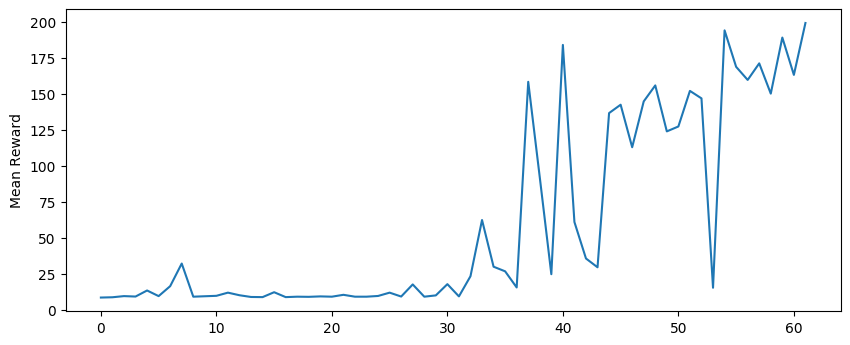

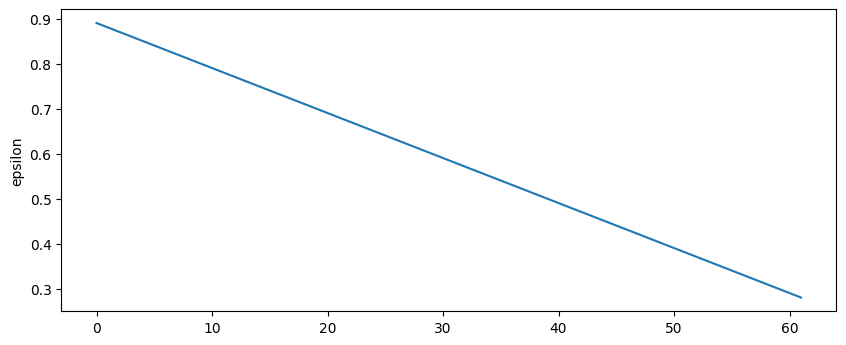

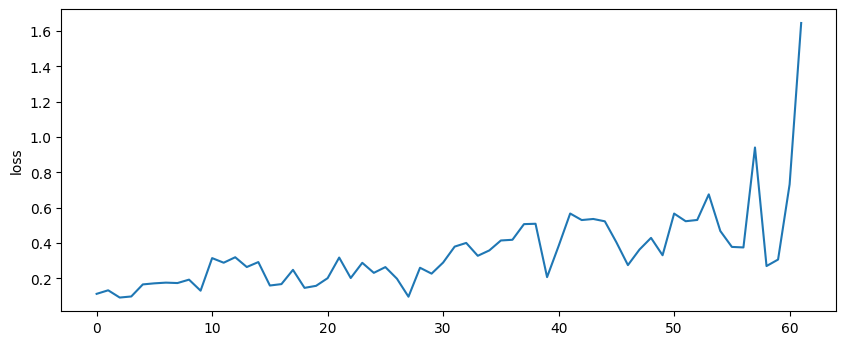

In [20]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot(mean_reward_trace)
plt.ylabel('Mean Reward');
plt.show();

plt.figure(figsize=(10,4), dpi=100)
plt.plot(epsilon_trace)
plt.ylabel('epsilon');
plt.show();


plt.figure(figsize=(10,4), dpi=100)
plt.plot(loss_trace)
plt.ylabel('loss');
plt.show();

In [21]:
s = test_env.reset()
episode_reward = 0.0
while True:
    # we dont want any randomness within the network at evaluation time
    s_v = torch.FloatTensor([s]).to(DEVICE)
    Qsa = net(s_v).data.cpu().numpy()
    a = np.argmax(Qsa[0])
    s,r,d,_ = test_env.step(a)
    episode_reward += r
    test_env.render()
    if d:
        test_env.close()
        break